In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/libraries.py /content
import libraries


# Check if the Colab runtime is GPU or CPU
if libraries.torch.cuda.is_available():
    device = libraries.torch.device("cuda")
    print("Using GPU acceleration.")
    libraries.torch.backends.cudnn.deterministic = True  # Set CuDNN to deterministic mode
else:
    device = libraries.torch.device("cpu")
    print("Using CPU.")
# Set random seed for reproducibility
random_seed = 42
libraries.torch.manual_seed(random_seed)
# If using GPU, set CUDA seed
if device.type == "cuda":
    libraries.torch.cuda.manual_seed(random_seed)


Using CPU.


In [ ]:
!pip install torchviz
!pip install torchsummary
!apt-get install graphviz -y
!pip install graphviz
!pip install Pillow
from torchviz import make_dot


In [ ]:
# Define the data path
DATA_PATH = '/content/drive/MyDrive/sipakmed/sipakmed/'

Mounted at /content/drive


In [ ]:
# Import the module
!cp /content/drive/MyDrive/sipakmed/modular/dataset_management.py /content

import dataset_management
import os


i used this to make sure there isn't duplicated data and data for training was succesful

In [ ]:
# Get a list of all image file paths
file_paths = []
categories = []

for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('.bmp'):
            file_path = libraries.os.path.join(root, file)
            file_paths.append(file_path)
            if 'normal' in file_path:
                categories.append(0)
            else:
                categories.append(1)

In [ ]:
# Create a DataFrame
df = libraries.pd.DataFrame({'filename (X)': file_paths, 'category (Y)': categories})
df

In [ ]:
import os
import shutil
import random
# Specify the path to your dataset on Google Drive
drive_path = '/content/drive/MyDrive/sipakmed/sipakmed/'

# Define the output directory for your divided dataset on Google Drive
output_dir = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training'


to check if my data are balanced regarding the training ones or not

Directory: /content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/, BMP File Count: 5886
Directory: /content/drive/MyDrive/sipakmed/sipakmed/, BMP File Count: 11772
Total BMP File Count in '/content/drive/MyDrive/sipakmed/sipakmed/': 11772
Total BMP File Count in '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/': 5886


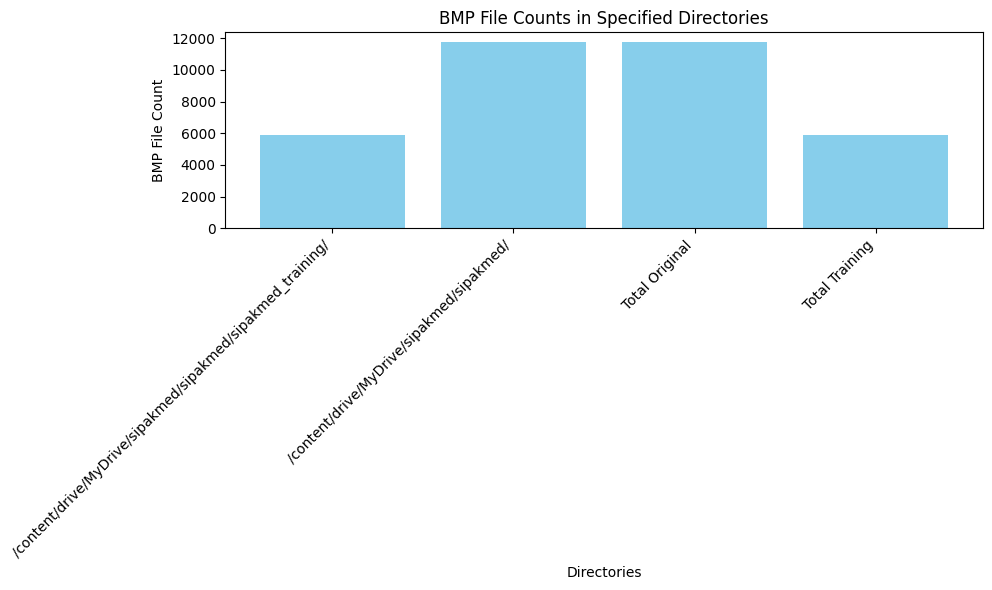

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/sipakmed/modular')

import check_balanced_data
check_balanced_data.check_balanced_data()


data balance in normal and atypical

In [ ]:
import random
import dataset_management

# Function to balance data by randomly undersampling the majority class
def balance_data(train_files):
    normal_files = [file for file in train_files if 'normal' in file]
    atypical_files = [file for file in train_files if 'atypical' in file]

    min_samples = min(len(normal_files), len(atypical_files))

    balanced_data = random.sample(normal_files, min_samples) + random.sample(atypical_files, min_samples)
    return balanced_data


In [ ]:
def check_balance(data):
    normal_count = sum(1 for file in data if 'normal' in file)
    atypical_count = sum(1 for file in data if 'atypical' in file)

    return normal_count, atypical_count

# Call the balance_data function to get the balanced dataset
balanced_train_data = balance_data(train_files)

# Check the balance
normal_count, atypical_count = check_balance(balanced_train_data)
print(f"Normal samples: {normal_count}, Atypical samples: {atypical_count}")

if normal_count == atypical_count:
    print("The data is balanced.")
else:
    print("The data is not balanced.")


Normal samples: 2179, Atypical samples: 2179
The data is balanced.


Data preprocessing and loading using torchvision


 load images and their labels from the balanced_dataset:

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/data_loading.py /content
import data_loading

Do you want to apply data processing? (y/n): n
Data processing skipped.
Number of images in 'normal' class: 1159
Number of images in 'atypical' class: 1005


In [ ]:
import libraries

PREPROCESSED_PATH = "/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/preprocessed_classified/"

# Model
class VGG19Model(libraries.nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19Model, self).__init__()
        self.model = vgg19(pretrained=True)
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Update the PTImageDataset class
class PTImageDataset(libraries.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.files = self.get_files(data_dir)
        self.num_classes = 2  # Assuming you have 2 classes
        self.class_names = ["normal", "abnormal"]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img_tensor = torch.load(img_path)

        # Apply transformations if specified
        if self.transform:
            img_tensor = self.transform(img_tensor)

        # Extract label from the file path or filename
        label = self.extract_label(img_path)

        return img_tensor, label

    def extract_label(self, file_path):
        # Modify this logic based on your actual file naming or directory structure
        parts = file_path.split(os.path.sep)
        class_name = parts[-2]
        return 0 if class_name == "normal" else 1  # Adjust based on your class names

    def get_files(self, data_dir):
        all_files = []
        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.endswith(".pt"):
                    all_files.append(os.path.join(root, file))
        return all_files

# Define transformations for training and validation/test
train_transform = libraries.transforms.Compose([
    libraries.transforms.Resize((224, 224)),  # Resize to VGG19 input size
    libraries.transforms.ToTensor(),
    libraries.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Use the modified PTImageDataset with transformations
dataset = PTImageDataset(PREPROCESSED_PATH, transform=train_transform)



In [ ]:
from torchsummary import summary

model = VGG19Model()

# Define a function to print a concise summary
def concise_summary(model, input_size):
    summary(model, input_size, device="cuda" if torch.cuda.is_available() else "cpu")

# Print the concise summary
input_size = (3, 125, 125)
concise_summary(model, input_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 92.4MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 125, 125]           1,792
              ReLU-2         [-1, 64, 125, 125]               0
            Conv2d-3         [-1, 64, 125, 125]          36,928
              ReLU-4         [-1, 64, 125, 125]               0
         MaxPool2d-5           [-1, 64, 62, 62]               0
            Conv2d-6          [-1, 128, 62, 62]          73,856
              ReLU-7          [-1, 128, 62, 62]               0
            Conv2d-8          [-1, 128, 62, 62]         147,584
              ReLU-9          [-1, 128, 62, 62]               0
        MaxPool2d-10          [-1, 128, 31, 31]               0
           Conv2d-11          [-1, 256, 31, 31]         295,168
             ReLU-12          [-1, 256, 31, 31]               0
           Conv2d-13          [-1, 256, 31, 31]         590,080
             ReLU-14          [-1, 256,

In [ ]:
import libraries
from torchvision.models import vgg19

# Load VGG-19
model = vgg19(pretrained=True)

# Extract only the classifier (fully connected) layer
classifier = model.classifier

# Create dummy input
dummy_input = libraries.torch.randn(1, 512 * 7 * 7)  # Adjust the input size based on your model

# Visualize just the classifier layer
make_dot(classifier(dummy_input), params=dict(classifier.named_parameters())).render("vgg19_classifier_viz", format="png")
from google.colab import files
files.download('vgg19_classifier_viz.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        epoch_acc += correct / total

    epoch_loss /= len(train_loader.dataset)
    epoch_acc /= len(train_loader.dataset)

    return epoch_loss, epoch_acc

# Placeholder for the test function
def test(model, test_loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            epoch_loss += criterion(outputs, labels).item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            epoch_acc += correct

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss /= len(test_loader.dataset)
    epoch_acc /= len(test_loader.dataset)

    return epoch_loss, epoch_acc, all_preds, all_labels

# Dataset and dataloaders
PREPROCESSED_PATH = "/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/preprocessed_classified/"
dataset = PTImageDataset(PREPROCESSED_PATH)
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = libraries.random_split(dataset, [train_size, val_size, test_size])
# Set number of worker processes for DataLoader
num_workers = os.cpu_count()
train_loader = libraries.DataLoader(train_dataset, batch_size=16, num_workers=num_workers, shuffle=True)
val_loader = libraries.DataLoader(val_dataset, batch_size=16, num_workers=num_workers, shuffle=False)
test_loader = libraries.DataLoader(test_dataset, batch_size=16, num_workers=num_workers, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time  # Import the 'time' module
from torch.utils.data import DataLoader  # Import DataLoader
from torchvision.models import vgg19  # Import VGG19
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

# Assuming you have a VGG19Model class
class VGG19Model(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19Model, self).__init__()
        self.model = vgg19(pretrained=True)
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Assuming you have defined train and test functions

# Assuming you have defined train_loader, val_loader, test_loader

# Model, optimizer, loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG19Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Check if a pre-trained model should be loaded
load_pretrained = input("Do you want to load a pre-trained model? (yes/no): ").lower()

if load_pretrained == "yes":
    # Check if a previously saved model exists
    saved_model_path = "vgg19_adam.pth"  # Adjust the filename as needed
    if os.path.exists(saved_model_path):
        model.load_state_dict(torch.load(saved_model_path))
        print("Pre-trained model loaded.")
    else:
        print(f"No pre-trained model found at {saved_model_path}. Training a new model.")
        load_pretrained = "no"

if load_pretrained != "yes":
    # Training loop
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    # Early stopping
    patience = 5
    best_val_loss = float('inf')  # Initialize here
    epochs_no_improve = 0

    for epoch in range(20):
        # Training
        start_time = time.time()
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        elapsed_time = time.time() - start_time

        # Validation
        start_time = time.time()
        val_loss, val_acc, _, _ = test(model, val_loader, criterion)
        elapsed_time_val = time.time() - start_time

        print(f"Epoch {epoch + 1} - "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Elapsed Time: {elapsed_time:.2f}s "
              f"Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f} Elapsed Time: {elapsed_time_val:.2f}s")

        # Debugging: Print some sample predictions and true labels
        sample_inputs, sample_labels = next(iter(train_loader))
        sample_inputs, sample_labels = sample_inputs.to(device), sample_labels.to(device)
        sample_outputs = model(sample_inputs)
        _, sample_preds = torch.max(sample_outputs, 1)
        print("Sample Predictions:", sample_preds.cpu().numpy())
        print("Sample True Labels:", sample_labels.cpu().numpy())

        # Append metrics for later plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping!")
            break

    # Testing
    test_loss, test_acc, test_preds, test_labels = test(model, test_loader, criterion)
    print(f"Final Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")


Do you want to load a pre-trained model? (yes/no): n
Epoch 1 - Train Loss: 0.3220 Train Acc: 0.0546 Elapsed Time: 1060.67s Validation Loss: 0.1815 Validation Acc: 0.9329 Elapsed Time: 96.76s
Sample Predictions: [0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0]
Sample True Labels: [0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0]
Epoch 2 - Train Loss: 0.1815 Train Acc: 0.0598 Elapsed Time: 1059.92s Validation Loss: 0.5134 Validation Acc: 0.7778 Elapsed Time: 94.58s
Sample Predictions: [0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0]
Sample True Labels: [0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0]
Epoch 3 - Train Loss: 0.1306 Train Acc: 0.0603 Elapsed Time: 1035.76s Validation Loss: 0.2419 Validation Acc: 0.9051 Elapsed Time: 96.51s
Sample Predictions: [1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1]
Sample True Labels: [1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1]
Epoch 4 - Train Loss: 0.1229 Train Acc: 0.0609 Elapsed Time: 1068.92s Validation Loss: 0.1602 Validation Acc: 0.9329 Elapsed Time: 95.69s
Sample Predictions: [0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0]
Sample True Label

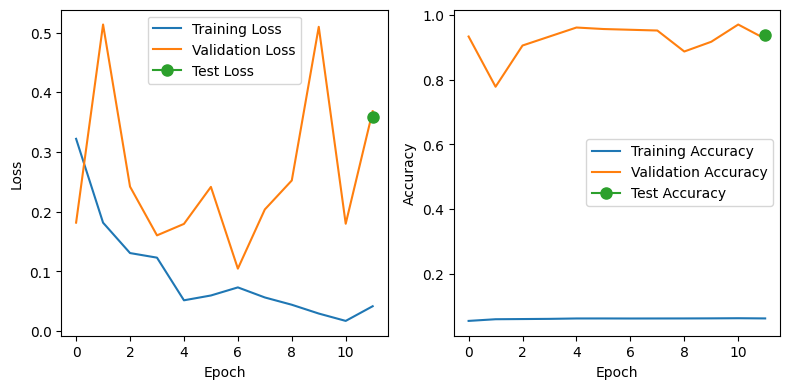

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/acc_loss_curves.py /content
import acc_loss_curves

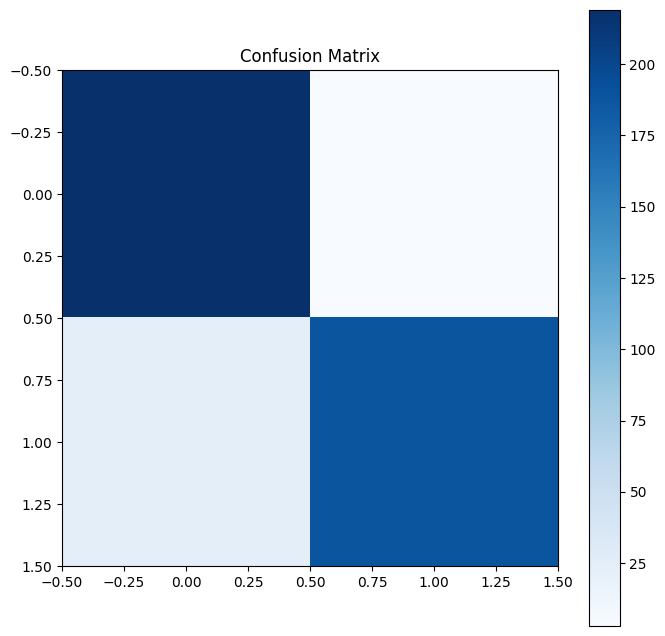

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/confusion_matrix.py /content
import confusion_matrix

report for validation set

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/evaluation_metrics.py /content
import evaluation_metrics


F1 Score: 0.9092
Precision: 0.9180
Recall: 0.9101
Classification Report:
               precision    recall  f1-score   support

      normal       0.87      0.98      0.92       232
    abnormal       0.98      0.83      0.90       202

    accuracy                           0.91       434
   macro avg       0.92      0.90      0.91       434
weighted avg       0.92      0.91      0.91       434

Do you want to save the trained model? (yes/no): y


 Evaluation Metrics:
 - F1 Score (0.9374): A balanced measure of precision and recall.
 - Precision (0.9416): The accuracy of positive predictions.
 - Recall (0.9378): The ability to identify all relevant instances.
 - Classification Report: Detailed metrics for each class ("normal" and "abnormal").
   - For "normal": High precision (few false positives), moderate recall.
   - For "abnormal": Good precision, very high recall (few false negatives).
 - Accuracy (0.94): Overall correct predictions.
 - Macro Avg and Weighted Avg: Averages for precision, recall, and F1-score.
In summary, the model seems to perform well with a good balance between precision and recall. The detailed classification report provides insights into the performance for each class.






In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Number of trainable parameters in the model: {num_params}")


Number of trainable parameters in the model: 139578434


measuring the inference time for a single forward pass with a sample input, not per epoch.

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/sample_input_time.py /content
import sample_input_time

Inference time for a sample input: 0.3228271007537842 seconds


**this is part related to vgg-16 from the 2018 paper i am using as a point of comaparison **

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Training results
train_loss = [0.7634, 0.6919, 0.6935, 0.6935, 0.6934, 0.6933, 0.6933, 0.6933, 0.6934, 0.6932, 0.6932, 0.6931, 0.6932, 0.6932, 0.6933, 0.6933]
train_acc = [0.5072, 0.5123, 0.5000, 0.4844, 0.4928, 0.4848, 0.4852, 0.4915, 0.4954, 0.4928, 0.5059, 0.5068, 0.4987, 0.4958, 0.4992, 0.4806]

# Validation results
val_loss = [0.6916, 0.6935, 0.6943, 0.6929, 0.6931, 0.6935, 0.6928, 0.6935, 0.6927, 0.6940, 0.6932, 0.6931, 0.6926, 0.6926, 0.6927, 0.6928]
val_acc = [0.5957, 0.4043, 0.4043, 0.5957, 0.4043, 0.4043, 0.5957, 0.4043, 0.5957, 0.4043, 0.4043, 0.5957, 0.5957, 0.5957, 0.5957, 0.5957]

# Calculate averages
final_train_loss = np.mean(train_loss)
final_train_acc = np.mean(train_acc)
final_val_loss = np.mean(val_loss)
final_val_acc = np.mean(val_acc)

# Convert accuracies to percentages
final_train_acc_percentage = final_train_acc * 100
final_val_acc_percentage = final_val_acc * 100

# Calculate F1 score
train_predictions = np.where(np.array(train_acc) > 0.5, 1, 0)  # Assuming threshold of 0.5 for binary classification
val_predictions = np.where(np.array(val_acc) > 0.5, 1, 0)
train_labels = np.array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0])  # Replace with actual labels
val_labels = np.array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0])  # Replace with actual labels

final_train_f1 = f1_score(train_labels, train_predictions)
final_val_f1 = f1_score(val_labels, val_predictions)

print(f"Final Training Loss: {final_train_loss}")
print(f"Final Training Accuracy: {final_train_acc_percentage}%")
print(f"Final Training F1 Score: {final_train_f1}")

print(f"\nFinal Validation Loss: {final_val_loss}")
print(f"Final Validation Accuracy: {final_val_acc_percentage}%")
print(f"Final Validation F1 Score: {final_val_f1}")


Final Training Loss: 0.69759375
Final Training Accuracy: 49.58375%
Final Training F1 Score: 0.3333333333333333

Final Validation Loss: 0.6930562499999999
Final Validation Accuracy: 51.19625%
Final Validation F1 Score: 0.9411764705882353
